# Conduction-Band Lineups in SiGe heterostructures
- Reference: K. Driscoll and R. Paiella, J. Appl. Phys. 102, 093103 (2007) (https://doi.org/10.1063/1.2803896)
- For QC lasers with: 
    - Compressively strained Ge wells
    - Tensile strained Si(1-x)Ge(x) barriers
    - Virtual substrate Si(1-y)Ge(y)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from aftershoq.materials import *

# Virtual substrate Ge content
y = np.array([0.8,0.9,1])
# Ge content
x_ge = np.linspace(0,1,100)

ecl = np.zeros((len(y),len(x_ge)))
ecdel2 = np.zeros((len(y),len(x_ge)))
ecdel4 = np.zeros((len(y),len(x_ge)))

# Attention: Aftershoq convention is with Si-content and not Ge
for i in range(len(y)):
    vs = SiGe(x=(1-y[i]))
    for j in range(len(x_ge)):
        sige = SiGe(x=(1-x_ge[j]),subs=vs)
        sige.calcStrain_IV()
        
        ecl[i][j] = sige.params["EcL"]
        ecdel2[i][j] = sige.params["EcDel2"]
        ecdel4[i][j] = sige.params["EcDel4"]

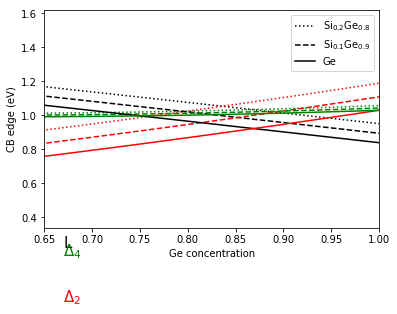

In [2]:
# Reproduce with aftershoq - not normalized
fig, ax = plt.subplots()
ax.plot(x_ge, ecl[0],color='black',linestyle=':',label='Si$_{0.2}$Ge$_{0.8}$')
ax.plot(x_ge, ecdel2[0],color='red',linestyle=':')
ax.plot(x_ge, ecdel4[0],color='green',linestyle=':')

ax.plot(x_ge, ecl[1],color='black',linestyle='--',label='Si$_{0.1}$Ge$_{0.9}$')
ax.plot(x_ge, ecdel2[1],color='red',linestyle='--')
ax.plot(x_ge, ecdel4[1],color='green',linestyle='--')

ax.plot(x_ge, ecl[2],color='black',label='Ge')
ax.plot(x_ge, ecdel2[2],color='red')
ax.plot(x_ge, ecdel4[2],color='green')

plt.text(0.67, 0.22, 'L', {'color': 'black', 'fontsize': 15})
plt.text(0.67, -0.1, '$\Delta_2$', {'color': 'red', 'fontsize': 15})
plt.text(0.67, 0.17, '$\Delta_4$', {'color': 'green', 'fontsize': 15})

ax.set_xlim(0.65,1)
#ax.set_ylim(-0.125,0.275)
ax.set(xlabel='Ge concentration',ylabel='CB edge (eV)')
ax.legend()
plt.show()

## Direct implementation to double check

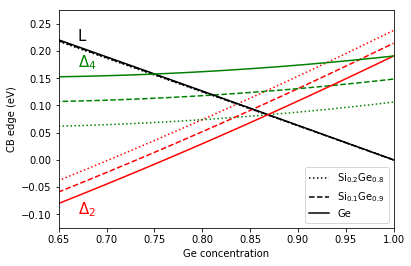

In [3]:
# Table 
a_si = 5.431
a_ge = 5.657
# elastic constants (10^6 N cm^-2)
c11_si = 16.75
c11_ge = 13.15
c12_si = 6.5
c12_ge = 4.94
# Spin-orbit coupling (eV)
del0_si = 0.044
del0_ge = 0.296

# deformation potentials (eV)
acl_av_si = -3.12
acl_av_ge = -2.78
acdel_av_si = 1.72
acdel_av_ge = 1.31
def_u_del_si = 9.16
def_u_del_ge = 9.42

#Functions to interpolate
def Ev_avg(x,y):
    """
    Average valence-band edge in eV.
    Interpolated formula.
    """
    return (0.47 - 0.06*y)*(x-y)

def del0(x):
    """
    Spin-orbit coupling in eV.
    """
    return np.interp(x,[0,1],[del0_si,del0_ge])

def Eg(x,valley='L'):
    """
    Unstrained bandgaps in eV
    """
    if valley == 'L':
        return (2.01-1.27*x)
    else:
        return 1.155-0.43*x+0.206*x**2

def a_sub(y):
    """
    In-plane lattice constant of the unstrained substrate
    """
    return  np.interp(y,[0,1],[a_si,a_ge])

def a_lay(x):
    """
    In-plane lattice constant of the unstrained adlayer
    """
    return np.interp(x,[0,1],[a_si,a_ge])

def ac_av(x, valley='L'):
    if valley == 'L':
        return np.interp(x,[0,1],[acl_av_si, acl_av_ge])
    else:
        return np.interp(x,[0,1],[acdel_av_si, acdel_av_ge])
    
def c11(x):
    """
    Elastic constant in 10^6 N*cm^(-2)
    """
    return np.interp(x,[0,1],[c11_si, c11_ge])

def c12(x):
    """
    Elastic constant in 10^6 N*cm^(-2)
    """
    return np.interp(x,[0,1],[c12_si, c12_ge])

def def_u_del(x):
    return np.interp(x,[0,1],[def_u_del_si,def_u_del_ge])

def eps_par(x,y):
    """
    Parallel strain component (dimensionless).
    """
    return (a_sub(y)/a_lay(x)-1)

def eps_perp(x,y):
    """
    Perpendicular strain component (dimensionless).
    """
    return (-2*c12(x)*eps_par(x,y)/c11(x))

def Eh(x,y,valley='L'):
    """
    Bandgap shift due to hydrostatic strain in eV.
    """
    return ac_av(x,valley)*(2*eps_par(x,y)+eps_perp(x,y))

def Eu(x,y,valley='L'):
    """
    Bandgap shift due to uniaxial strain in eV.
    """
    if valley == 'L':
        return x*0
    if valley == 'del2':
        return 2*def_u_del(x)*(eps_perp(x,y)-eps_par(x,y))/3
    if valley == 'del4':
        return -def_u_del(x)*(eps_perp(x,y)-eps_par(x,y))/3
    
def Ec(x,y, valley = 'L'):
    return Ev_avg(x,y) + del0(x)/3 + Eg(x,valley) + Eh(x,y,valley) +Eu(x,y,valley)
     #return Ev_avg(x,y) + del0(x)/3 + Eg(x,valley) + Eh(x,y,valley)

#%% Conduction band minima - normalized
fig, ax = plt.subplots()
ax.plot(x_ge, Ec(x_ge,y[0],valley='L')-Ec(1,y[0]),color='black',linestyle=':',label='Si$_{0.2}$Ge$_{0.8}$')
ax.plot(x_ge, Ec(x_ge,y[0],valley='del2')-Ec(1,y[0]),color='red',linestyle=':')
ax.plot(x_ge, Ec(x_ge,y[0],valley='del4')-Ec(1,y[0]),color='green',linestyle=':')

ax.plot(x_ge, Ec(x_ge,y[1],valley='L')-Ec(1,y[1]),color='black',linestyle='--',label='Si$_{0.1}$Ge$_{0.9}$')
ax.plot(x_ge, Ec(x_ge,y[1],valley='del2')-Ec(1,y[1]),color='red',linestyle='--')
ax.plot(x_ge, Ec(x_ge,y[1],valley='del4')-Ec(1,y[1]),color='green',linestyle='--')

ax.plot(x_ge, Ec(x_ge,y[2],valley='L')-Ec(1,y[2]),color='black',label='Ge')
ax.plot(x_ge, Ec(x_ge,y[2],valley='del2')-Ec(1,y[2]),color='red')
ax.plot(x_ge, Ec(x_ge,y[2],valley='del4')-Ec(1,y[2]),color='green')

plt.text(0.67, 0.22, 'L', {'color': 'black', 'fontsize': 15})
plt.text(0.67, -0.1, '$\Delta_2$', {'color': 'red', 'fontsize': 15})
plt.text(0.67, 0.17, '$\Delta_4$', {'color': 'green', 'fontsize': 15})

ax.set_xlim(0.65,1)
ax.set_ylim(-0.125,0.275)
ax.set(xlabel='Ge concentration',ylabel='CB edge (eV)')
ax.legend()
plt.show()

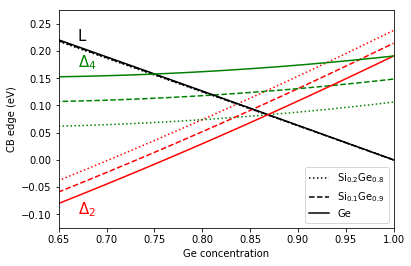

In [4]:
#%% Reproduce with aftershoq - but re-normalization with formulas from above
fig, ax = plt.subplots()
ax.plot(x_ge, ecl[0]-Ec(1,y[0]),color='black',linestyle=':',label='Si$_{0.2}$Ge$_{0.8}$')
ax.plot(x_ge, ecdel2[0]-Ec(1,y[0]),color='red',linestyle=':')
ax.plot(x_ge, ecdel4[0]-Ec(1,y[0]),color='green',linestyle=':')

ax.plot(x_ge, ecl[1]-Ec(1,y[1]),color='black',linestyle='--',label='Si$_{0.1}$Ge$_{0.9}$')
ax.plot(x_ge, ecdel2[1]-Ec(1,y[1]),color='red',linestyle='--')
ax.plot(x_ge, ecdel4[1]-Ec(1,y[1]),color='green',linestyle='--')

ax.plot(x_ge, ecl[2]-Ec(1,y[2]),color='black',label='Ge')
ax.plot(x_ge, ecdel2[2]-Ec(1,y[2]),color='red')
ax.plot(x_ge, ecdel4[2]-Ec(1,y[2]),color='green')

plt.text(0.67, 0.22, 'L', {'color': 'black', 'fontsize': 15})
plt.text(0.67, -0.1, '$\Delta_2$', {'color': 'red', 'fontsize': 15})
plt.text(0.67, 0.17, '$\Delta_4$', {'color': 'green', 'fontsize': 15})

ax.set_xlim(0.65,1)
ax.set_ylim(-0.125,0.275)
ax.set(xlabel='Ge concentration',ylabel='CB edge (eV)')
ax.legend()
plt.show()